# 🚦 Traffic Congestion Level Prediction

**Goal**: Predict congestion level (classification problem)

**Key Difference from Speed Prediction**:
- This is **classification** (predicting categories: Low/Medium/High congestion)
- We'll use **Average Speed** as a feature (it's not leakage when predicting congestion)
- We'll use accuracy, F1-score, and confusion matrix as metrics

In [1]:
!pip install kagglehub

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download dataset
path = kagglehub.dataset_download("preethamgouda/banglore-city-traffic-dataset")
print("Path to dataset files:", path)

# Load data
df = pd.read_csv(path + "/Banglore_traffic_Dataset.csv")
print(f"\nDataset shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'banglore-city-traffic-dataset' dataset.
Path to dataset files: /kaggle/input/banglore-city-traffic-dataset

Dataset shape: (8936, 16)


,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
0,2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No
1,2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No
2,2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No
3,2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No
4,2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No


Congestion Level distribution:
Congestion Level
100.000000    3884
94.953360        1
41.879021        1
55.182334        1
99.994420        1
              ... 
75.862103        1
58.551107        1
31.615053        1
93.393800        1
58.590261        1
Name: count, Length: 5053, dtype: int64

Unique values: [100.          28.34799386  79.03882288 ...  35.87148256  72.63915188
  43.40982073]


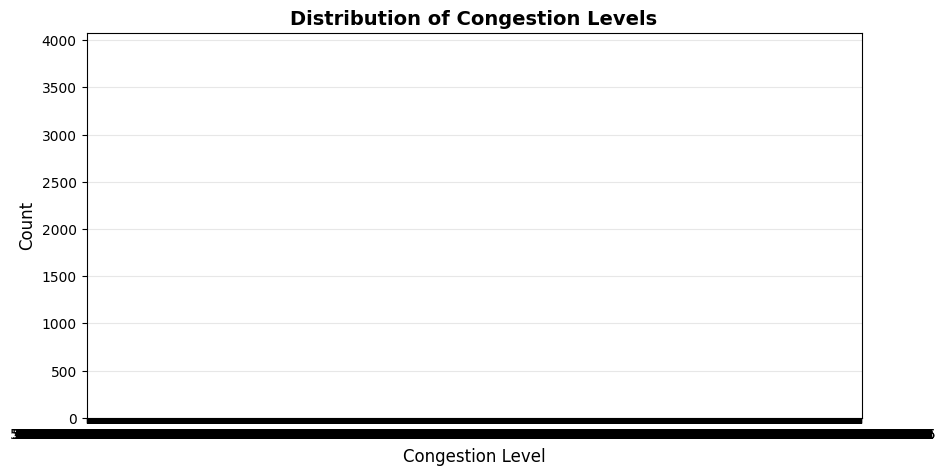

In [4]:
# Check Congestion Level distribution
print("Congestion Level distribution:")
print(df['Congestion Level'].value_counts())
print(f"\nUnique values: {df['Congestion Level'].unique()}")

# Visualize distribution
plt.figure(figsize=(10, 5))
df['Congestion Level'].value_counts().plot(kind='bar', color='steelblue')
plt.xlabel('Congestion Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Congestion Levels', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [5]:
# Data cleaning
df = df.dropna()
df = df.drop_duplicates()
df = df.drop(columns=["Date"])  # Drop date (no temporal encoding)

# Convert Roadwork to binary
df["Roadwork and Construction Activity"] = (
    df["Roadwork and Construction Activity"]
    .str.strip()
    .str.lower()
    .map({"yes": 1, "no": 0})
)

print("✅ Data cleaned")
df.info()

✅ Data cleaned
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Area Name                           8936 non-null   object 
 1   Road/Intersection Name              8936 non-null   object 
 2   Traffic Volume                      8936 non-null   int64  
 3   Average Speed                       8936 non-null   float64
 4   Travel Time Index                   8936 non-null   float64
 5   Congestion Level                    8936 non-null   float64
 6   Road Capacity Utilization           8936 non-null   float64
 7   Incident Reports                    8936 non-null   int64  
 8   Environmental Impact                8936 non-null   float64
 9   Public Transport Usage              8936 non-null   float64
 10  Traffic Signal Compliance           8936 non-null   float64
 11  Parking Usage               

In [6]:
# Define target (Congestion Level)
y = df["Congestion Level"].copy()

# Build features
X = df.drop(columns=[
    "Congestion Level",        # target
    "Environmental Impact",    # duplicate of Traffic Volume
    "Area Name",               # high-cardinality nominal
    "Road/Intersection Name",  # high-cardinality nominal
])

# One-hot encode Weather Conditions
X = pd.get_dummies(X, columns=["Weather Conditions"], drop_first=True)

print("Features used:", X.columns.tolist())
print(f"Shape: {X.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")

Features used: ['Traffic Volume', 'Average Speed', 'Travel Time Index', 'Road Capacity Utilization', 'Incident Reports', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Roadwork and Construction Activity', 'Weather Conditions_Fog', 'Weather Conditions_Overcast', 'Weather Conditions_Rain', 'Weather Conditions_Windy']
Shape: (8936, 14)

Target distribution:
Congestion Level
100.000000    3884
94.953360        1
41.879021        1
55.182334        1
99.994420        1
              ... 
75.862103        1
58.551107        1
31.615053        1
93.393800        1
58.590261        1
Name: count, Length: 5053, dtype: int64


In [7]:
# Encode target if it's categorical strings (e.g., 'Low', 'Medium', 'High')
from sklearn.preprocessing import LabelEncoder

if y.dtype == 'object':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print("Target encoding:")
    for i, label in enumerate(le.classes_):
        print(f"  {label} -> {i}")
    y = pd.Series(y_encoded, index=y.index, name='Congestion Level')
else:
    print("Target is already numeric")

print(f"\nFinal target range: {y.min()} to {y.max()}")

Target is already numeric

Final target range: 5.160279008043586 to 100.0


In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in train set:\n{y_train.value_counts()}")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# Model 1: Logistic Regression (baseline)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print("=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)
print(f"Accuracy: {lr_acc:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

In [ ]:
# Model 2: Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print("=" * 60)
print("RANDOM FOREST CLASSIFIER")
print("=" * 60)
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

In [ ]:
# Model 3: Gradient Boosting Classifier
gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    subsample=0.8,
    random_state=42
)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
gbc_acc = accuracy_score(y_test, gbc_pred)
gbc_f1 = f1_score(y_test, gbc_pred, average='weighted')

print("=" * 60)
print("GRADIENT BOOSTING CLASSIFIER")
print("=" * 60)
print(f"Accuracy: {gbc_acc:.4f}")
print(f"F1-Score: {gbc_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, gbc_pred))

In [ ]:
# Ensemble: Voting Classifier (combine predictions)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf_clf),
        ('gbc', gbc)
    ],
    voting='soft'  # Use predicted probabilities
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred, average='weighted')

print("=" * 60)
print("VOTING ENSEMBLE (LR + RF + GBC)")
print("=" * 60)
print(f"Accuracy: {voting_acc:.4f}")
print(f"F1-Score: {voting_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, voting_pred))

In [ ]:
# Compare all models
results = {
    'Logistic Regression': {'Accuracy': lr_acc, 'F1': lr_f1},
    'Random Forest': {'Accuracy': rf_acc, 'F1': rf_f1},
    'Gradient Boosting': {'Accuracy': gbc_acc, 'F1': gbc_f1},
    'Voting Ensemble': {'Accuracy': voting_acc, 'F1': voting_f1}
}

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(results_df.to_string())

# Find best model
best_model = results_df['Accuracy'].idxmax()
best_acc = results_df['Accuracy'].max()
print(f"\n🏆 Best Model: {best_model} (Accuracy: {best_acc:.4f})")

In [ ]:
# Visualization: Model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison
model_names = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_names]
f1_scores = [results[m]['F1'] for m in model_names]

axes[0, 0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: F1-Score comparison
axes[0, 1].bar(model_names, f1_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Confusion Matrix for best model
best_pred = voting_pred if best_model == 'Voting Ensemble' else (
    gbc_pred if best_model == 'Gradient Boosting' else (
    rf_pred if best_model == 'Random Forest' else lr_pred
))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)
axes[1, 0].set_title(f'Confusion Matrix ({best_model})', fontsize=14, fontweight='bold')

# Plot 4: Feature Importances (from Gradient Boosting)
top_features = pd.Series(gbc.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
axes[1, 1].barh(top_features.index, top_features.values, color='steelblue')
axes[1, 1].set_xlabel('Importance', fontsize=12)
axes[1, 1].set_title('Top 10 Feature Importances (GBC)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save the best model (optional)
import joblib

# Save best model
best_model_obj = voting_clf if best_model == 'Voting Ensemble' else (
    gbc if best_model == 'Gradient Boosting' else (
    rf_clf if best_model == 'Random Forest' else lr
))

joblib.dump(best_model_obj, 'congestion_model.joblib')
print(f"✅ Best model ({best_model}) saved as 'congestion_model.joblib'")

# Example prediction
print("\n" + "=" * 60)
print("EXAMPLE PREDICTION")
print("=" * 60)
sample = X_test.iloc[0:1]
pred = best_model_obj.predict(sample)[0]
actual = y_test.iloc[0]
print(f"Predicted Congestion: {pred}")
print(f"Actual Congestion: {actual}")
print(f"Match: {'✅' if pred == actual else '❌'}")